In [1]:
import numpy as np

from optyx.core import channel

In [2]:
from optyx.qubit import *

In [3]:
Ket_0 = Ket(0)
Ket_1 = Ket(1)

Ket_plus = Ket("+")
Ket_minus = Ket("-")

Bra_0 = Bra(0)
Bra_1 = Bra(1)

Bra_plus = Bra("+")
Bra_minus = Bra("-")

Bit_0 = Bra(0, channel.bit)
Bit_1 = Bra(1, channel.bit)

CNOT = Z(1,2) @ Id(1) >> Id(1) @ X(2,1) @ Scalar(np.sqrt(2))
NOTC = X(1,2) @ Id(1) >> Id(1) @ Z(2,1) @ Scalar(np.sqrt(2))


X_ = X(1,1,0.5)
Z_ = Z(1,1,0.5)
H_ = H()

### Encoder for the [4,1,2] code

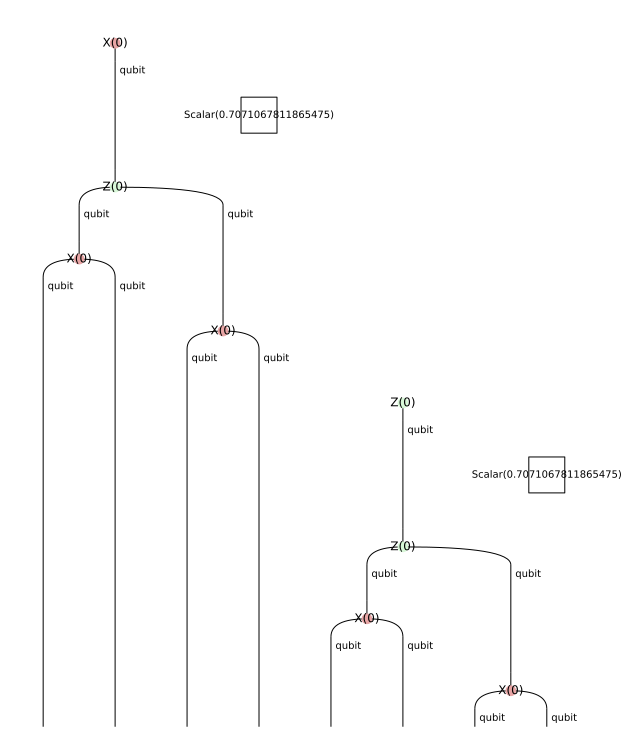

In [4]:
encoder = Z(1, 2) >> X(1, 2) @ X(1, 2)

# Defining the logical |0> and <0|
logical_0 = X(0,1) @ Scalar(1/np.sqrt(2)) >> encoder
logical_0_measurement = logical_0.dagger()

# Defining the logical |+> and <+|
logical_plus = Z(0,1) @ Scalar(1/np.sqrt(2)) >> encoder
logical_plus_measurement = logical_0.dagger()

(logical_0 @ logical_plus).draw()

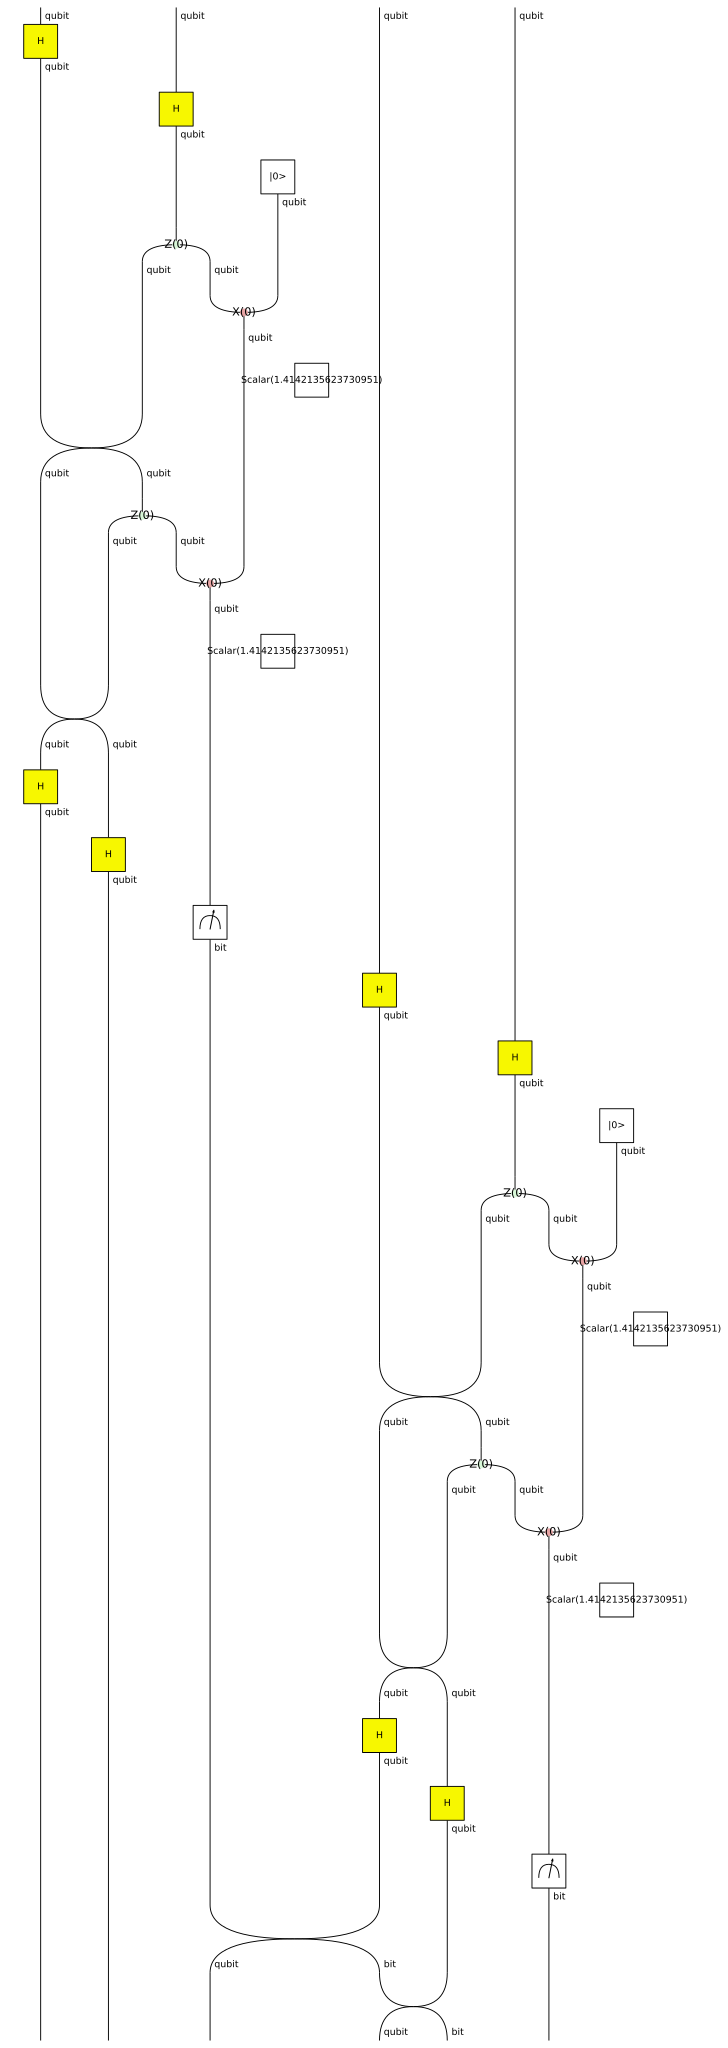

In [5]:
X_module = Id(1) @ CNOT >> channel.Diagram.permutation([1, 0, 2], channel.qubit ** 3) >> Id(1) @ CNOT >> channel.Diagram.permutation([1, 0, 2], channel.qubit ** 3)
X_parity_check = Id(2) @ Ket_0 >> X_module >> Id(2) @ MeasureQubits(1)
Z_parity_check = H_ @ H_ @ Ket_0 >> X_module >> H_ @ H_ @ MeasureQubits(1)

X_detector = X_parity_check @ X_parity_check >> channel.Diagram.permutation([0,1,3,4,2,5], channel.qubit ** 2 @ channel.bit @ channel.qubit ** 2 @ channel.bit)
Z_detector = Z_parity_check @ Z_parity_check >> channel.Diagram.permutation([0,1,3,4,2,5], channel.qubit ** 2 @ channel.bit @ channel.qubit ** 2 @ channel.bit)

Z_detector.draw()

### Defining the circuit with probabilistic bit-flips on data qubits

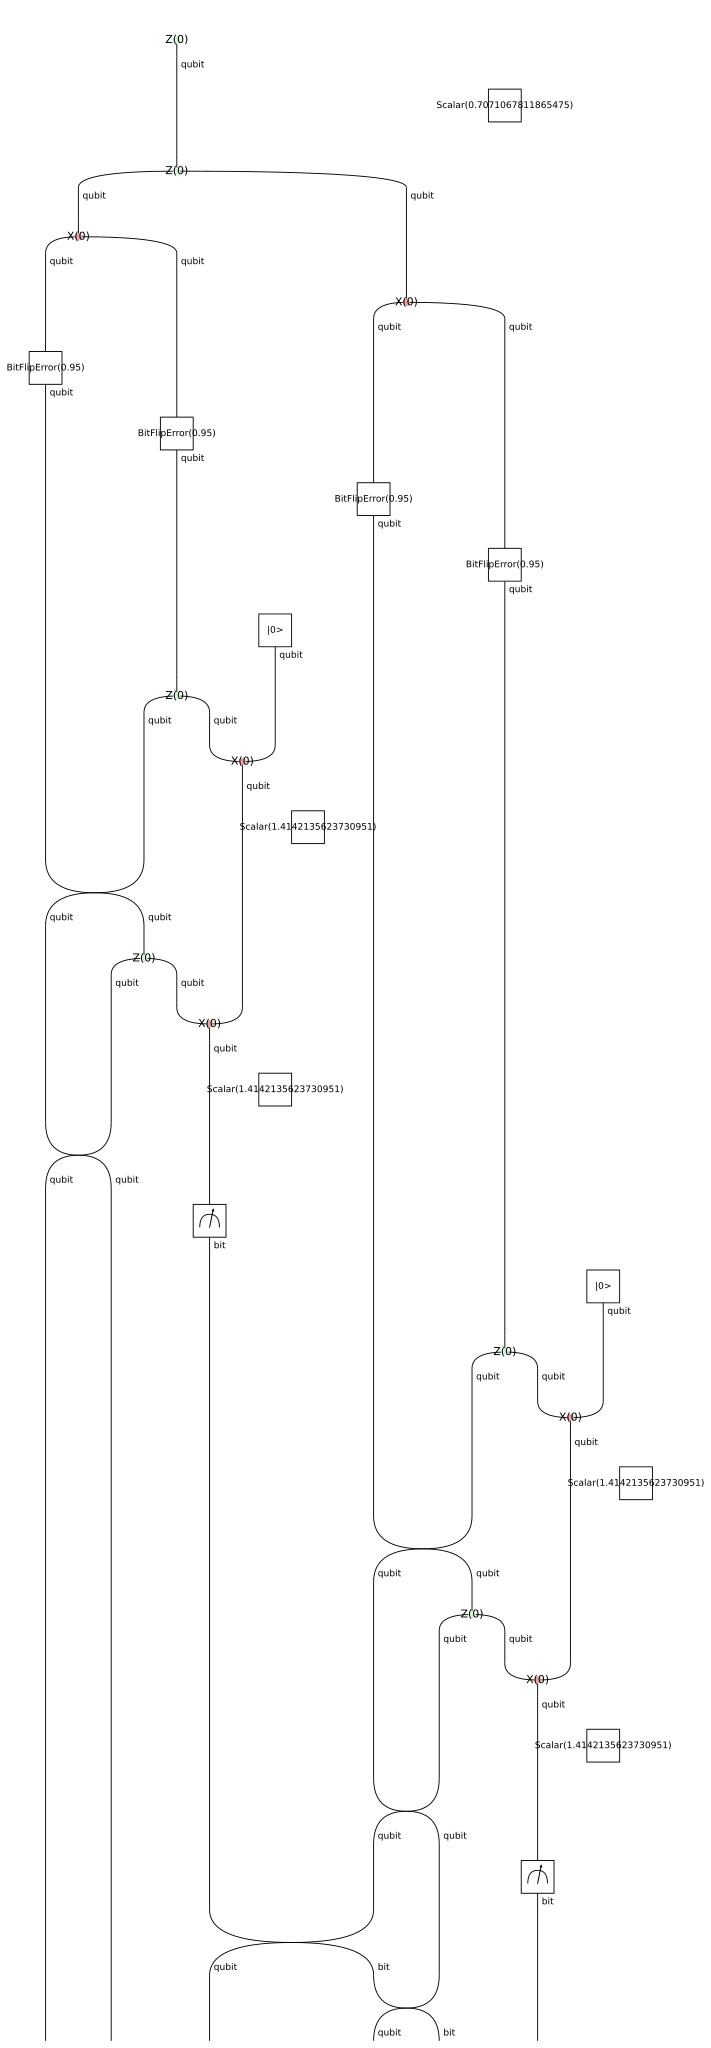

In [6]:
p_error = 0.95
Imperfect_circuit = logical_plus >> BitFlipError(p_error) ** 4 >> X_detector
Imperfect_circuit.draw()

### Computing the fidelity after one round of X error detection

In [7]:
P_s_eq_0 = Imperfect_circuit >> DiscardQubits(4) @ Bit_0 @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> logical_plus_measurement @ Bit_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity:", np.sqrt(fidelity).real)

Calculated fidelity: 0.9999999999999992


## Calculating the fidelity for the distributed [4,2,2] code with an imperfect Bell state on the network

### Defining the network Bell state from its density matrix

![Density Matrix](densityMatrix.png)

The state has a fidelity of 96.89(8)% to the |Ψ+⟩ Bell state.
https://www.nature.com/articles/s41586-024-08404-x

In [8]:
bell_density_re = np.array([
    [0.012, 0.014, 0.014, 0.000],
    [0.014, 0.508, 0.475, 0.008],
    [0.014, 0.475, 0.479, 0.009],
    [0.000, 0.008, 0.009, 0.000]
])
bell_density_im = np.exp(1j * np.pi * np.array([
    [0.000, -1.850, -1.825, -0.985],
    [1.850, 0.000, -0.002, -0.902],
    [1.825, 0.002, 0.000, -0.931],
    [0.985, 0.902, 0.931, 0.000]
]))

bell_density = np.multiply(bell_density_re, bell_density_im)
np.set_printoptions(precision=3)
print(bell_density)

[[ 0.012+0.j     0.012+0.006j  0.012+0.007j  0.   -0.j   ]
 [ 0.012-0.006j  0.508+0.j     0.475-0.003j -0.008-0.002j]
 [ 0.012-0.007j  0.475+0.003j  0.479+0.j    -0.009-0.002j]
 [-0.   +0.j    -0.008+0.002j -0.009+0.002j  0.   +0.j   ]]


In [9]:
from discopy import tensor

bell = diagram.Box(name="Bell", dom=diagram.bit ** 2, cod=diagram.bit ** 2)
bell.array = bell_density
bell.determine_output_dimensions = lambda input_dims: input_dims
bell.truncation = lambda input_dims, output_dims: tensor.Box("Bell", dom=tensor.Dim(2)**2, cod=tensor.Dim(2)**2, data=bell_density)
bell = (
    diagram.Spider(0, 2, typ=diagram.bit) >>
    diagram.Id(diagram.bit) @ diagram.Spider(0, 2, typ=diagram.bit) @ diagram.Id(diagram.bit) >>
    diagram.Diagram.permutation([0,1,3,2], diagram.bit**4) >>
    diagram.Id(diagram.bit ** 2) @ bell >>
    diagram.Diagram.permutation([0,2,1,3], diagram.bit**4)
)

Noisy_bell = channel.CQMap('Physical Bell', bell, dom=channel.Ty(), cod=channel.qubit ** 2)

#### Verifying fidelity

In [10]:
Perfect_Bell = channel.Channel("Perfect Bell", diagram.Spider(0,2,typ=diagram.bit) @ diagram.Scalar(1 / np.sqrt(2)))
Perfect_Bell_Effect = channel.Channel("Perfect Bell Effect", diagram.Id(diagram.bit) @ zx.X(1,1,0.5) >> diagram.Spider(2,0,typ=diagram.bit) @ diagram.Scalar(1 / np.sqrt(2)))

print("Calculated fidelity:", (Noisy_bell >> Perfect_Bell_Effect).double().to_tensor().eval().array.real)

Calculated fidelity: 0.9684906239066646


### Defining the circuit for the distributed physical implementation

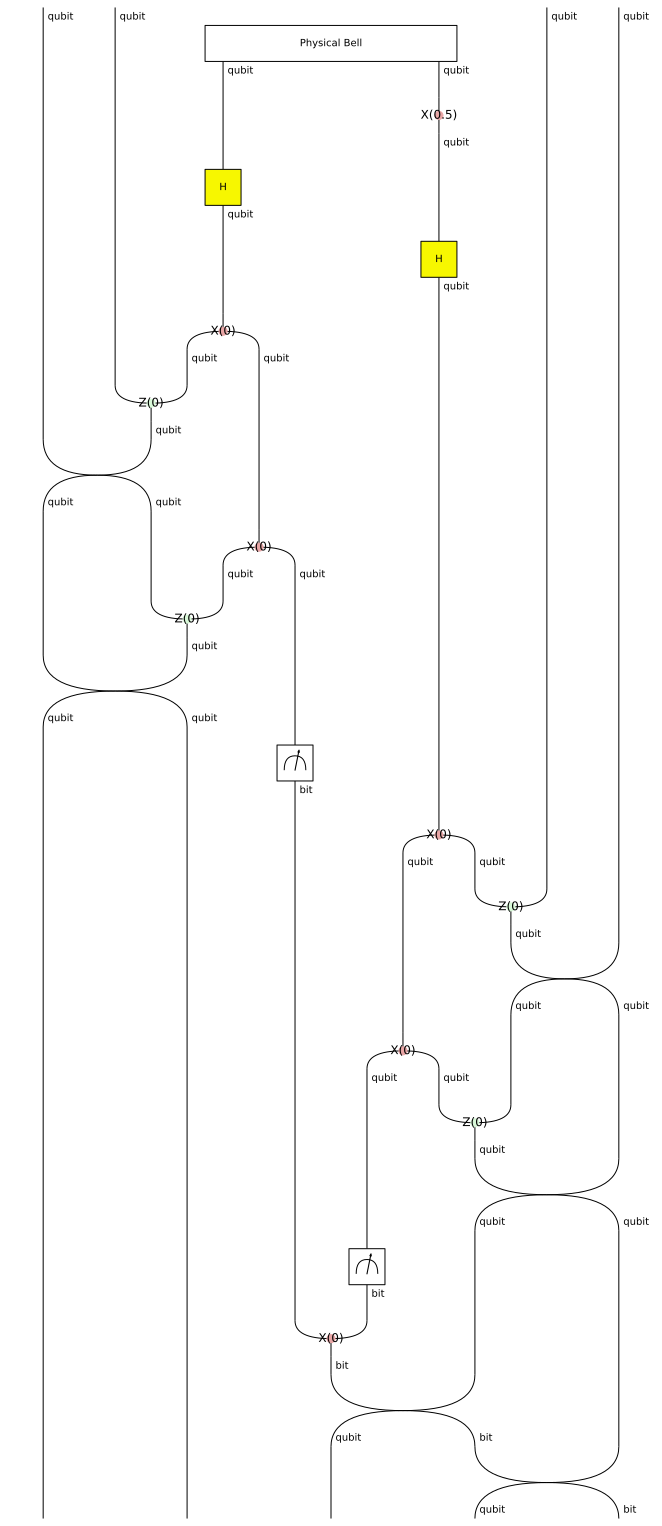

In [27]:
from optyx import classical

cnot = Id(1) @ X(1,2) >> Z(2,1) @ Id(1)
left_module_ = (
    Id(1) @ cnot >>
    channel.Diagram.permutation([1, 0, 2], channel.qubit ** 3) >>
    Id(1) @ cnot >>
    channel.Diagram.permutation([1, 0, 2], channel.qubit ** 3)
)

notc = X(1,2) @ Id(1) >> Id(1) @ Z(2,1)
right_module_ = (
    notc @ Id(1) >>
    channel.Diagram.permutation([0, 2, 1], channel.qubit ** 3) >>
    notc @ Id(1) >>
    channel.Diagram.permutation([0, 2, 1], channel.qubit ** 3)
)

left_module = left_module_ >> Id(2) @ MeasureQubits(1)
right_module = right_module_ >> MeasureQubits(1) @ Id(2)

X_ = X(1,1,0.5)
Z_ = Z(1,1,0.5)
H_ = H()
Left_X_module = left_module
Right_X_module = right_module

Left_Z_module = H_**2 @ Id(1) >> left_module_ >> H_**2 @ Id(1) >> Id(2) @ MeasureQubits(1)
Right_Z_module = Id(1) @ H_**2 >> right_module_ >> Id(1) @ H_**2 >> MeasureQubits(1) @ Id(2)

ClassicalDetector = classical.X(2,1,0)
ClassicalCopy = classical.X(2,1,0)

Physical_X_detector = (
    Id(2) @ (Noisy_bell >> Id(1) @ X_ >> H_ @ H_) @ Id(2) >>
    Left_X_module @ Right_X_module >>
    Id(2) @ ClassicalDetector @ Id(2) >>
    channel.Diagram.permutation([0,1,3,4,2], channel.qubit ** 2 @ channel.bit @ channel.qubit ** 2)
)
Physical_Z_detector = (
    Id(2) @ (Noisy_bell >> Id(1) @ X_ >> H_ @ H_) @ Id(2) >>
    Left_Z_module @ Right_Z_module >>
    Id(2) @ ClassicalDetector @ Id(2) >>
    channel.Diagram.permutation([0,1,3,4,2], channel.qubit ** 2 @ channel.bit @ channel.qubit ** 2)
)

Physical_X_detector.draw()

### Calculating fidelity for Z error detection

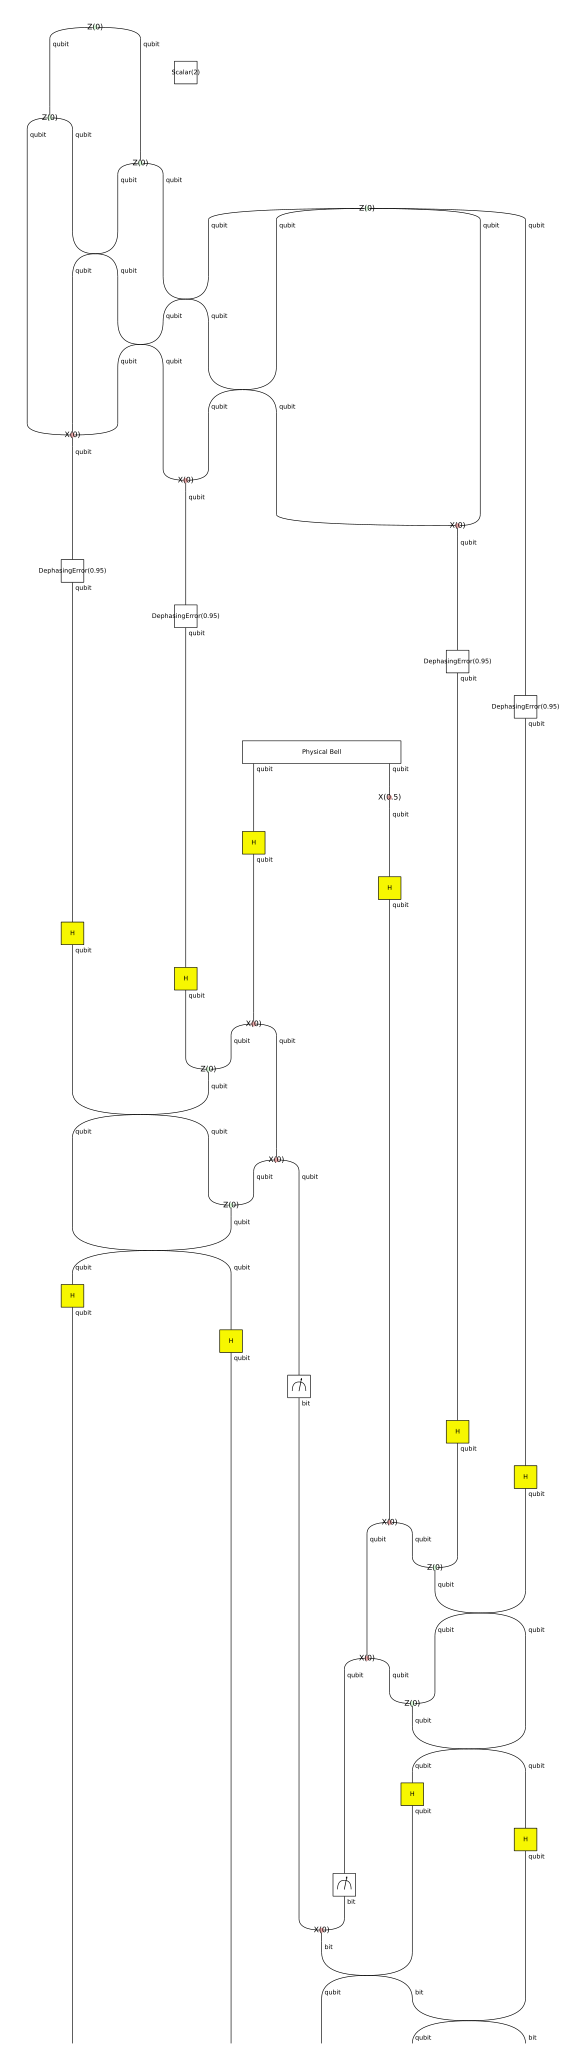

In [29]:
encoder = (
        Z(1, 2) @ Z(1, 2) @ Z(0, 4)
        >> channel.Diagram.permutation([0,2,4,1,5,3,6,7], channel.qubit ** 8)
        >> X(3,1) @ X(2,1) @ X(2,1) @ Id(1)
)

logical_bell = Z(0,2) @ Scalar(2) >> encoder
logical_bell_measurement = logical_bell.dagger()


Imperfect_circuit = logical_bell >> DephasingError(p_error)**4 >> Physical_Z_detector
Imperfect_circuit.draw()

In [30]:
P_s_eq_0 = Imperfect_circuit >> DiscardQubits(4) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> logical_bell_measurement @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity for Z error detection:", np.sqrt(fidelity.real))

Calculated fidelity for Z error detection: 0.9940683728075727


### Calculating fidelity for a whole round of Z and X error detection

In [31]:
Imperfect_circuit = (
    logical_bell >>
    DephasingError(p_error)**4 >>
    Physical_Z_detector >>
    BitFlipError(p_error)**4 @ channel.Diagram.id(channel.bit) >>
    Physical_X_detector @ channel.Diagram.id(channel.bit)
)

P_s_eq_0 = Imperfect_circuit >> DiscardQubits(4) @ Bit_0 @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> logical_bell_measurement @ Bit_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity a whole round of error detection:", np.sqrt(fidelity.real))

Calculated fidelity a whole round of error detection: 0.9882393885826845


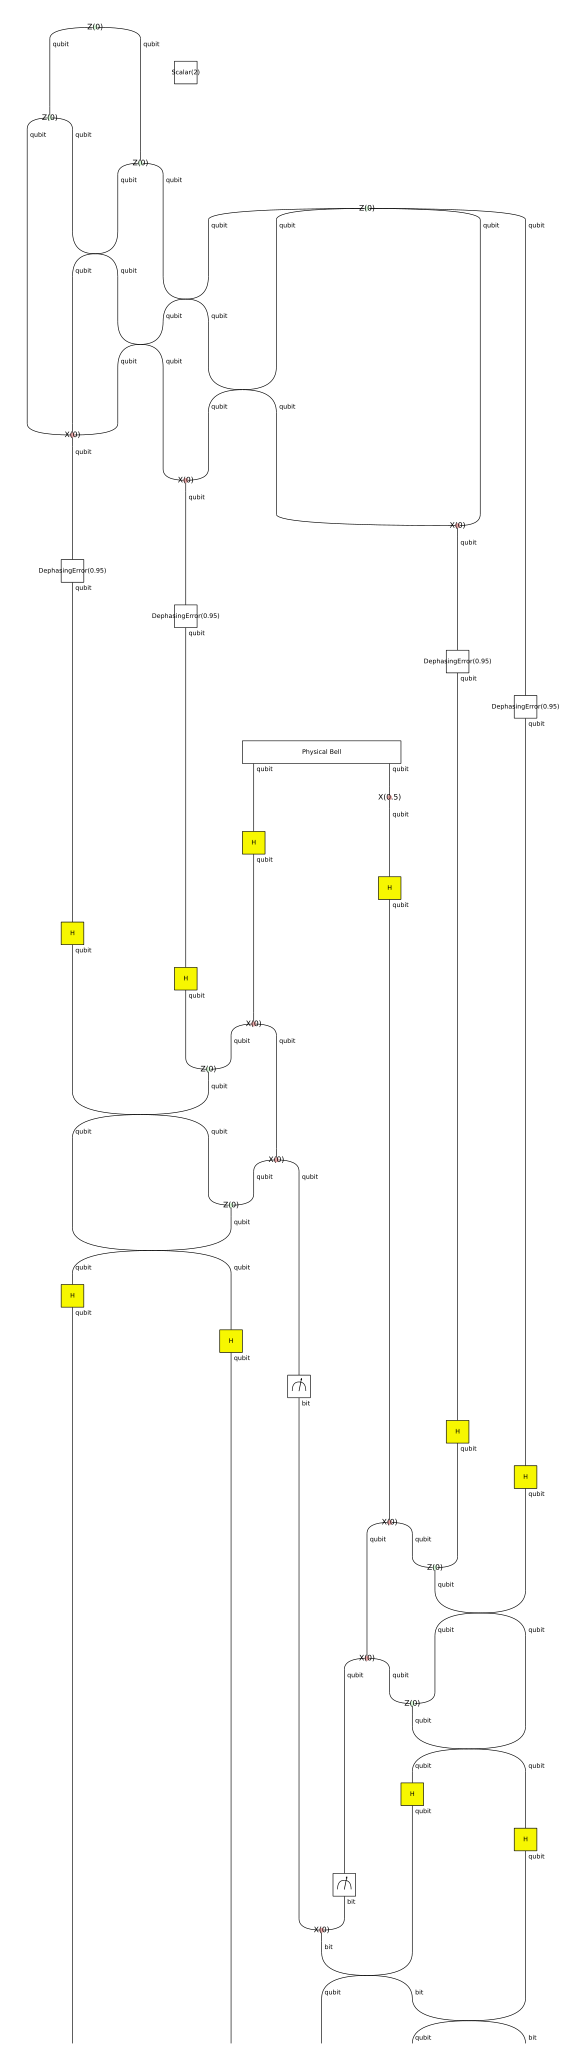

In [32]:
Imperfect_circuit = logical_bell >> DephasingError(p_error)**4 >> Physical_Z_detector
Imperfect_circuit.draw()

## Two-qubit bit-flip with a two-qubit phase-flip repetition code

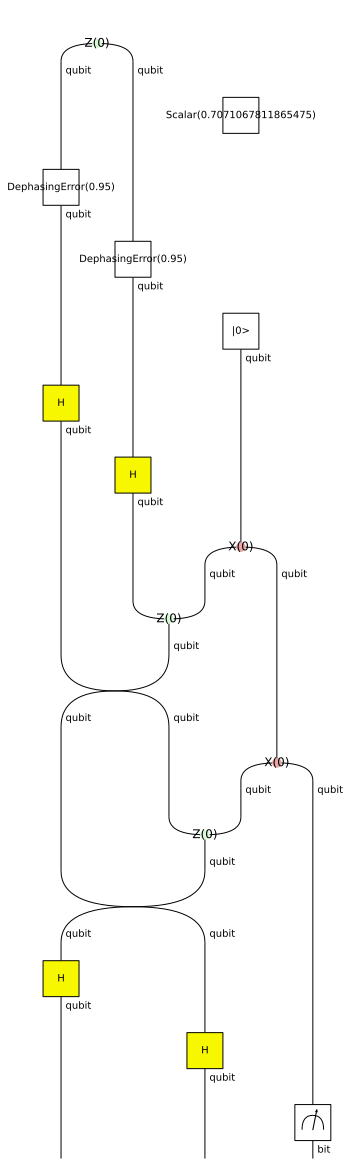

In [33]:
Left_Z_detector = Id(2) @ Ket_0 >> Left_Z_module

Logical_ket_0 = Z(0,2) @ Scalar(1 / np.sqrt(2))
Logical_bra_0 = Z(2,0) @ Scalar(1 / np.sqrt(2))

Imperfect_circuit = Logical_ket_0 >> DephasingError(p_error) @ DephasingError(p_error) >> Left_Z_detector
Imperfect_circuit.draw()

In [34]:
P_s_eq_0 = Imperfect_circuit >> DiscardQubits(2) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bra_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity a whole round of error detection:", fidelity.real)

Calculated fidelity a whole round of error detection: 0.9999999999999999


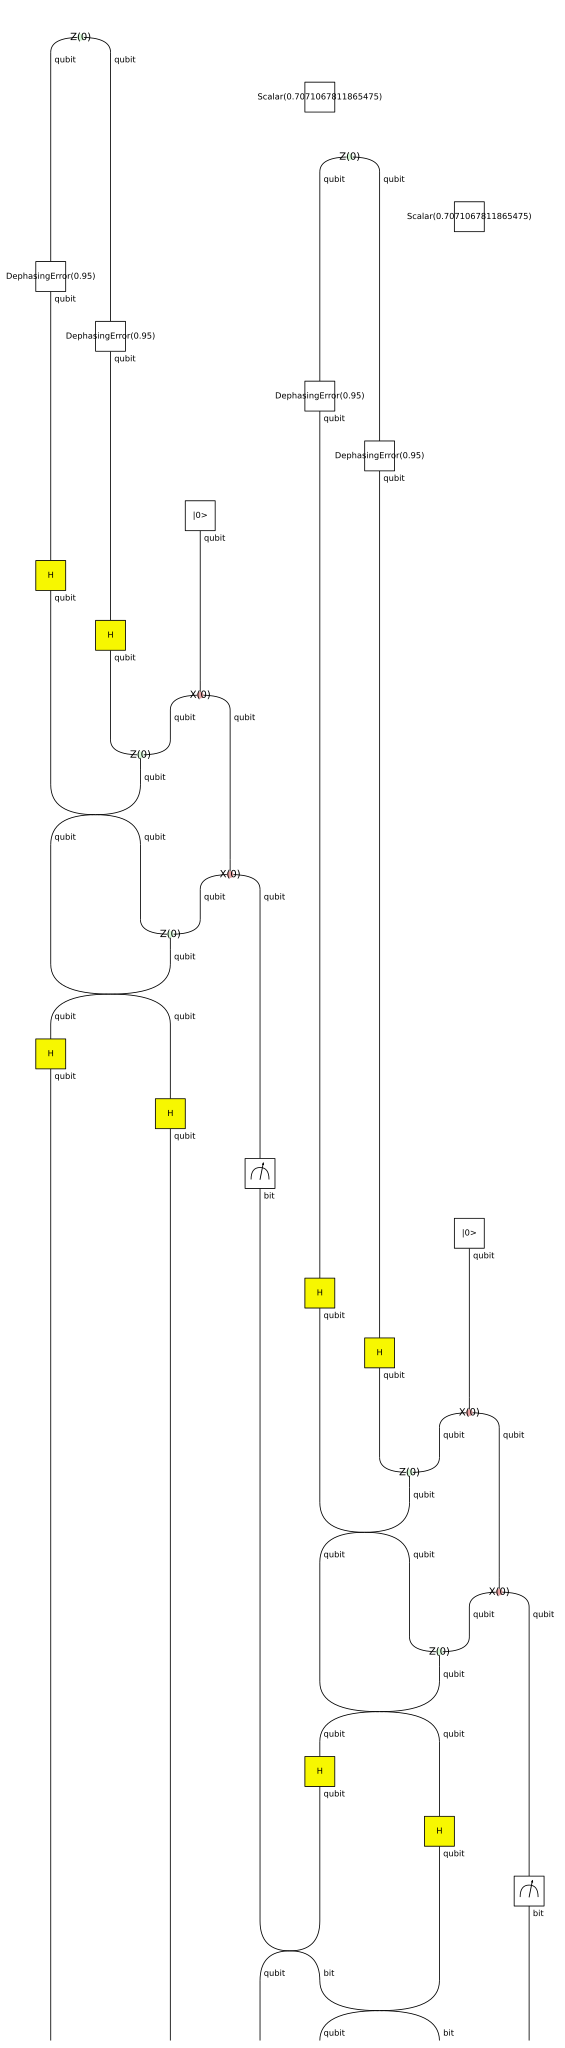

In [35]:
Z_repetition_detector = (
    Left_Z_detector @ Left_Z_detector >>
    channel.Diagram.permutation([0,1,3,4,2,5], channel.qubit ** 2 @ channel.bit @ channel.qubit ** 2 @ channel.bit)
)
X_repetition_detector = Physical_X_detector

Imperfect_circuit = Logical_ket_0 @ Logical_ket_0 >> DephasingError(p_error)**4 >> Z_repetition_detector
Imperfect_circuit.draw()

In [36]:
P_s_eq_0 = Imperfect_circuit >> DiscardQubits(4) @ Bit_0 @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> Logical_bra_0 @ Logical_bra_0 @ Bit_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity a whole round of error detection:", fidelity.real)

Calculated fidelity a whole round of error detection: 0.9999999999999996


Calculated fidelity a whole round of error detection: 0.49714692979130937


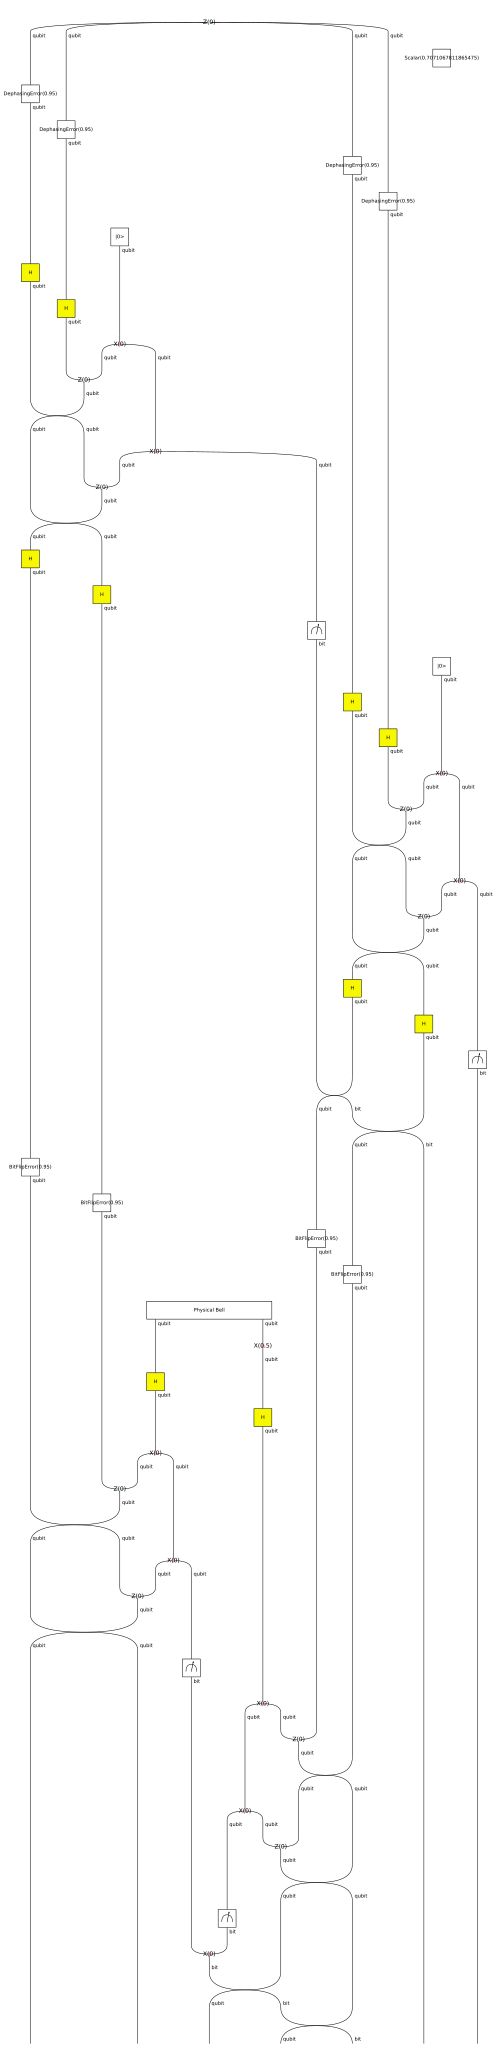

In [ ]:
logical_ket_00 = Z(0, 4) @ Scalar(1 / np.sqrt(2))
logical_bra_00 = Z(4, 0) @ Scalar(1 / np.sqrt(2))

Imperfect_circuit = (
    logical_ket_00 >>
    DephasingError(p_error)**4 >>
    Z_repetition_detector >>
    BitFlipError(p_error)**4 @ channel.Diagram.id(channel.bit ** 2) >>
    Physical_X_detector @ channel.Diagram.id(channel.bit ** 2)
)
# Imperfect_circuit = Logical_ket_00 >> diag_pow(DephasingError(p_error), 4) >> Z_repetition_detector

P_s_eq_0 = Imperfect_circuit >> DiscardQubits(4) @ Bit_0 @ Bit_0 @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> logical_bra_00 @ Bit_0 @ Bit_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity a whole round of error detection:", fidelity.real)
Imperfect_circuit.draw()

In [39]:
# dagger = lambda channel: Channel(name = channel.name + ".dagger()",
#                                  kraus = channel.kraus.dagger(),
#                                  dom= channel.cod,
#                                  cod= channel.dom)

def fidelity(input_state, p_error=0.95, n_rounds=1):
    Imperfect_circuit = (
        input_state >>
        DephasingError(p_error)**4 >>
        Z_repetition_detector >>
        BitFlipError(p_error)**4 @ channel.Diagram.id(channel.bit ** 2) >>
        Physical_X_detector @ channel.Diagram.id(channel.bit ** 2)
    )
    P_s_eq_0 = Imperfect_circuit >> DiscardQubits(4) @ Bit_0 @ Bit_0 @ Bit_0
    p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array
    P_00_and_s_eq_0 = Imperfect_circuit >> input_state.dagger() @ Bit_0 @ Bit_0 @ Bit_0
    p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array
    fidelity = p_00_and_s_eq_0 / p_s_eq_0
    return fidelity.real

fidelity(logical_ket_00, 0.95, 2)

0.49714692979130937

In [40]:
xs = np.linspace(0.9, 1, 20)
ys = [fidelity(logical_ket_00, error) for error in xs]

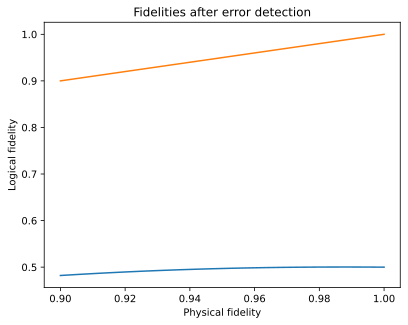

In [41]:
import matplotlib.pyplot as plt

plt.plot(xs, ys)
plt.plot(xs, xs)

plt.title("Fidelities after error detection")
plt.xlabel("Physical fidelity")
plt.ylabel("Logical fidelity")
plt.show()

In [43]:
xs = np.linspace(0.99, 1, 10)
ys = [fidelity(logical_ket_00, error) for error in xs]

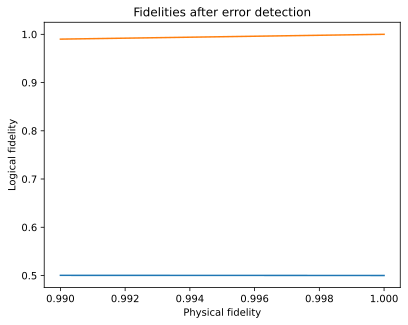

In [44]:
plt.plot(xs, ys)
plt.plot(xs, xs)

plt.title("Fidelities after error detection")
plt.xlabel("Physical fidelity")
plt.ylabel("Logical fidelity")
plt.show()

In [45]:
(Ket_plus**4 >> Physical_X_detector >> H_**4).double().to_tensor().eval().array

AxiomError: qubit @ qubit @ qubit @ Swap(bit, qubit) does not compose with H @ qubit @ qubit @ qubit: qubit @ qubit @ qubit @ qubit @ bit != qubit @ qubit @ qubit @ qubit.

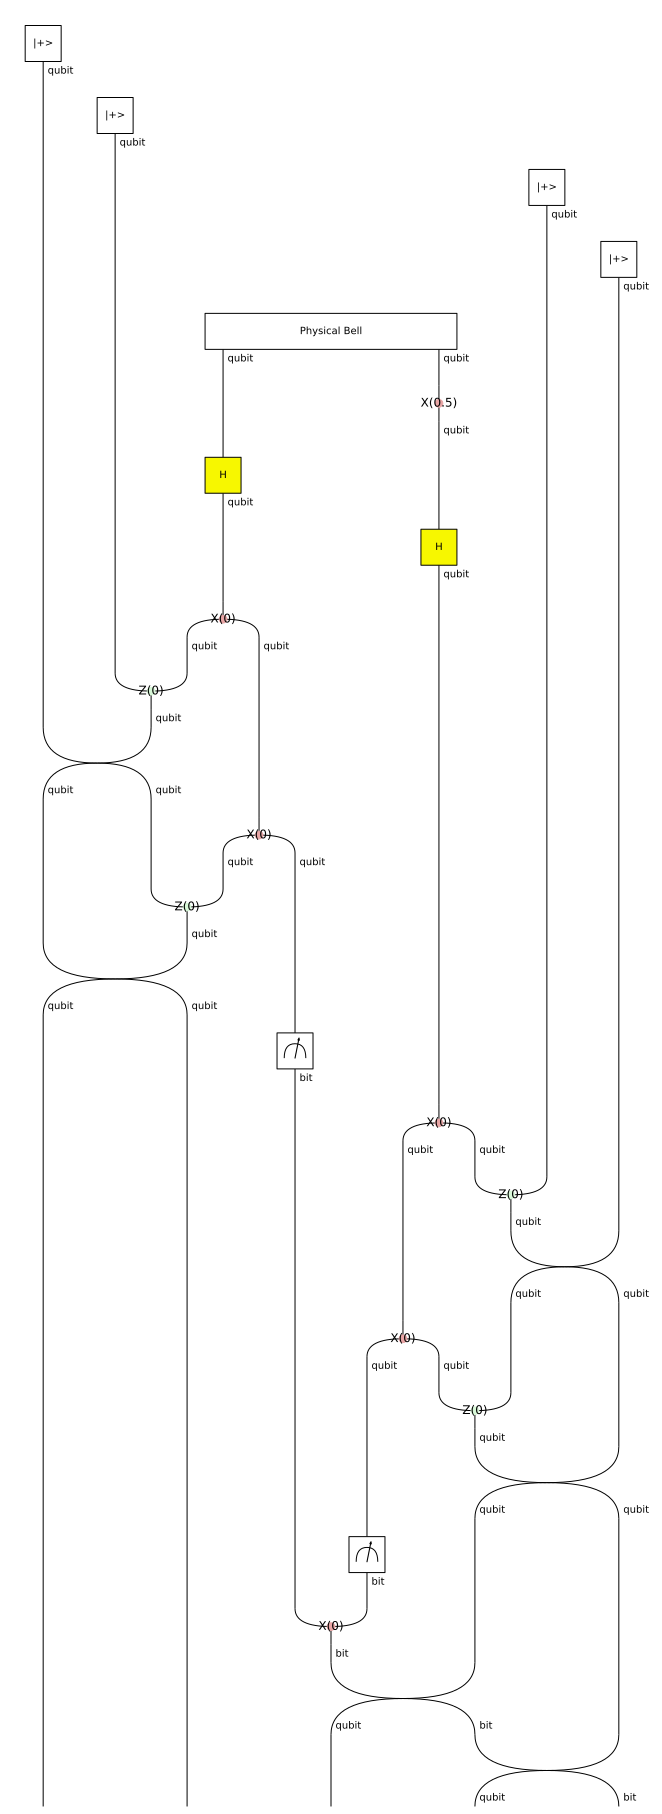

In [46]:
(Ket_plus**4 >> Physical_X_detector ).draw()

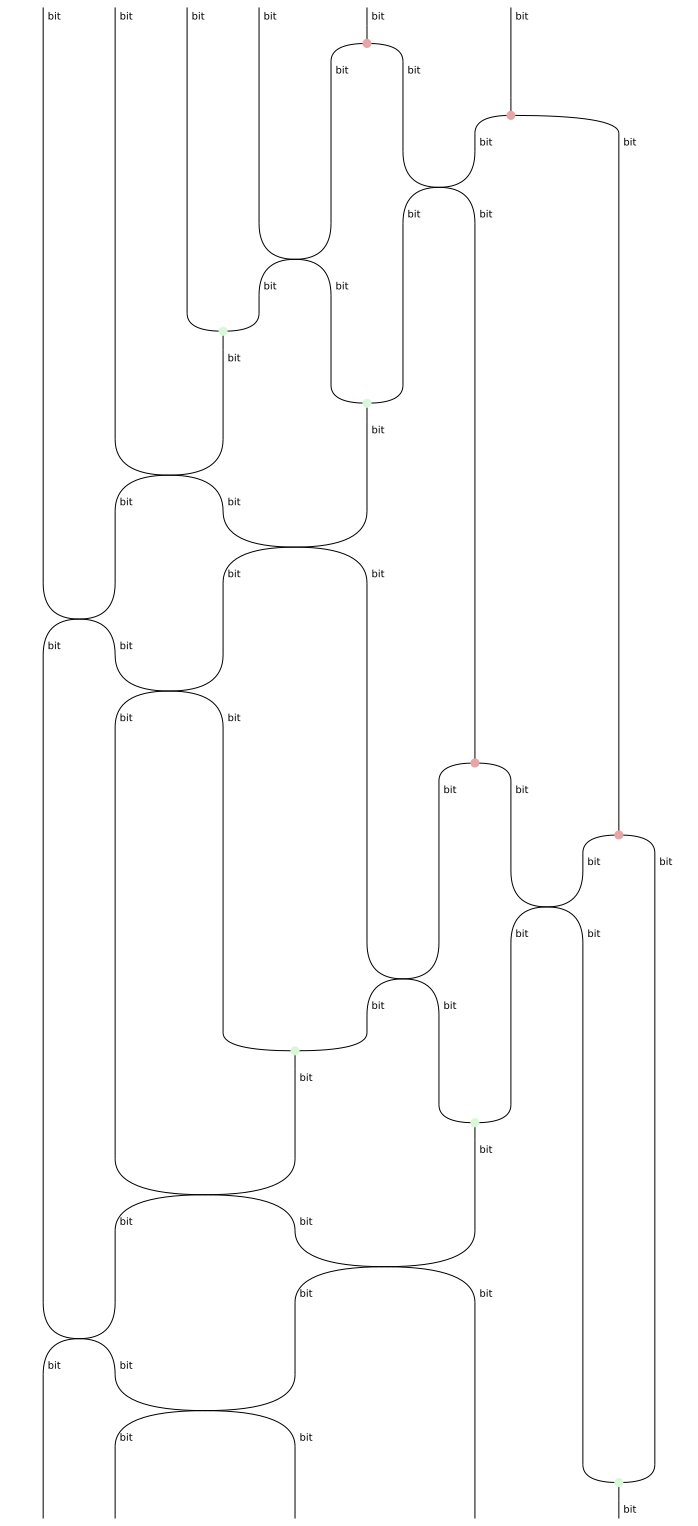

In [47]:
Left_X_module.double().draw()

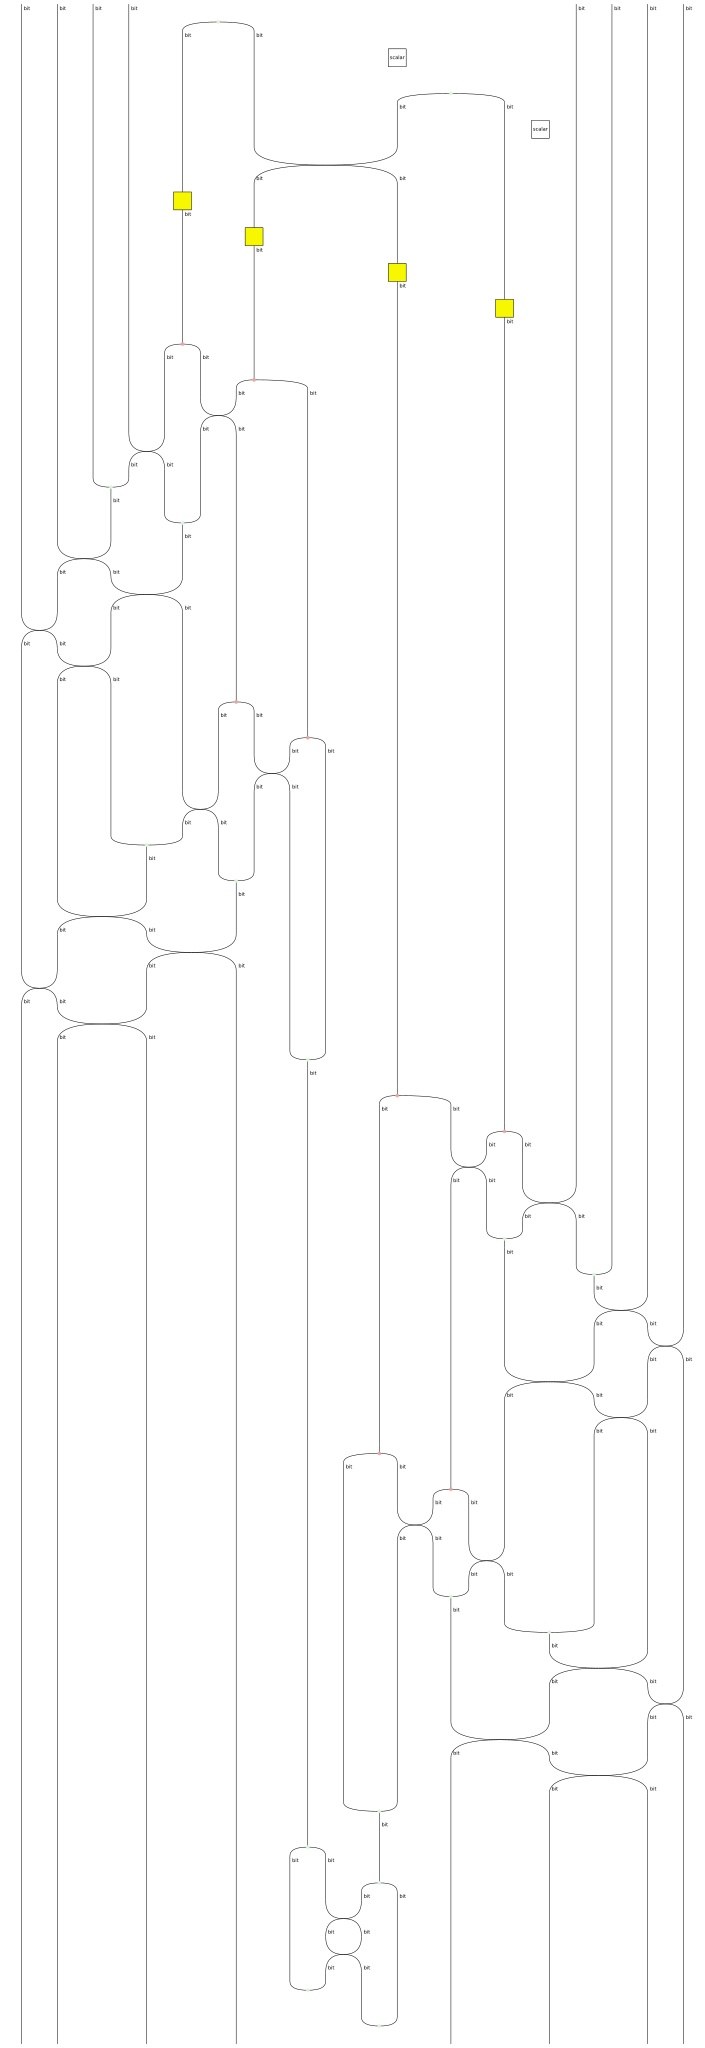

In [49]:
Physical_X_detector = Id(2) @ (Perfect_Bell >> H_ @ H_) @ Id(2) >> Left_X_module @ Right_X_module >> Id(2) @ channel.Discard(channel.bit ** 2) @ Id(2)
Physical_X_detector.double().draw()